## Impor Library

In [7]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

## Load Data

In [2]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform or transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx].values
        label = int(row[0])
        image = row[1:].astype(np.uint8).reshape(28, 28)
        image = np.stack([image] * 3, axis=-1)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, image

# DataLoader
train_dataset = FashionMNISTDataset("fashion-mnist_train.csv")
test_dataset = FashionMNISTDataset("fashion-mnist_test.csv")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


## Arsitektur Autoencoder

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 3 * 32 * 32),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 32, 32))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training Autoencoder

In [5]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        output = model(data)
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/10 - Loss: 0.0286
Epoch 2/10 - Loss: 0.0126
Epoch 3/10 - Loss: 0.0106
Epoch 4/10 - Loss: 0.0095
Epoch 5/10 - Loss: 0.0086
Epoch 6/10 - Loss: 0.0080
Epoch 7/10 - Loss: 0.0076
Epoch 8/10 - Loss: 0.0073
Epoch 9/10 - Loss: 0.0070
Epoch 10/10 - Loss: 0.0068


## Visualisasi Rekonstruksi

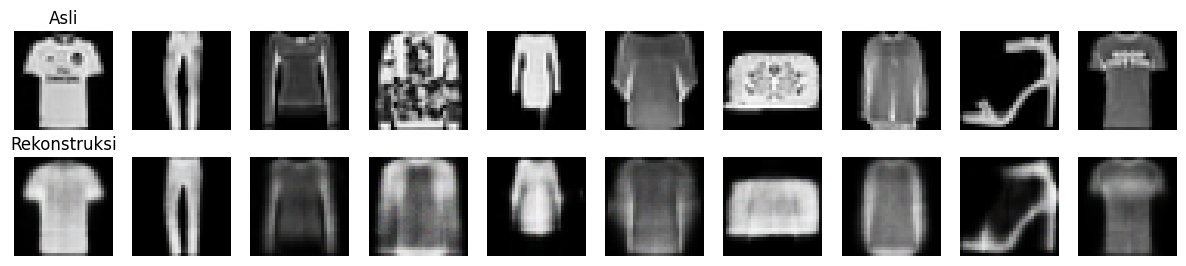

In [9]:
def show_reconstruction(model, loader):
    model.eval()
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = model(data)
            break
    fig, axs = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axs[0, i].imshow(data[i].cpu().permute(1, 2, 0))
        axs[0, i].axis('off')
        axs[1, i].imshow(output[i].cpu().permute(1, 2, 0))
        axs[1, i].axis('off')
    axs[0, 0].set_title("Asli")
    axs[1, 0].set_title("Rekonstruksi")
    plt.show()

show_reconstruction(model, test_loader)

## Generate (sampling dari latent space)

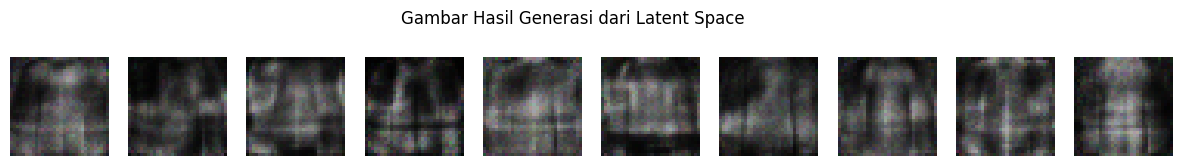

In [10]:
def generate_images(model, num_images=10):
    model.eval()
    with torch.no_grad():
        latent_vectors = torch.randn(num_images, 64).to(device)
        generated = model.decoder(latent_vectors)
        # Reshape to 3x32x32 for 3-channel images
        generated = generated.view(-1, 3, 32, 32).cpu()

    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 1.5, 2))
    for i in range(num_images):
        # Permute dimensions for displaying 3-channel images
        axs[i].imshow(generated[i].permute(1, 2, 0))
        axs[i].axis('off')
    plt.suptitle("Gambar Hasil Generasi dari Latent Space")
    plt.show()

generate_images(model)

## Overlay

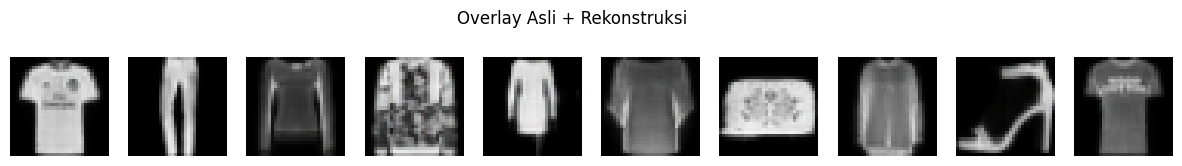

In [11]:
def show_overlay(model, loader, alpha=0.5, num_images=10):
    model.eval()
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = model(data)
            break
    data = data.cpu()
    output = output.cpu()

    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 1.5, 2))
    for i in range(num_images):
        original = data[i].permute(1, 2, 0).numpy()
        recon = output[i].permute(1, 2, 0).numpy()
        overlay = (alpha * original + (1 - alpha) * recon)

        axs[i].imshow(overlay)
        axs[i].axis('off')
    plt.suptitle("Overlay Asli + Rekonstruksi".format(alpha))
    plt.show()

show_overlay(model, test_loader, alpha=0.6)

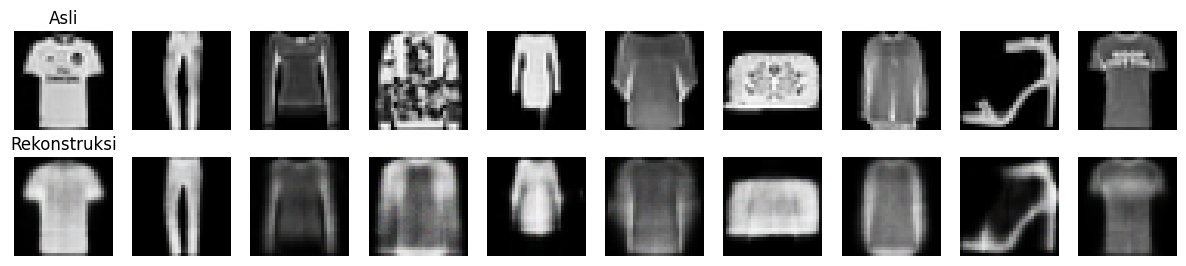

In [12]:
# Tampilkan hasil rekonstruksi
show_reconstruction(model, test_loader)

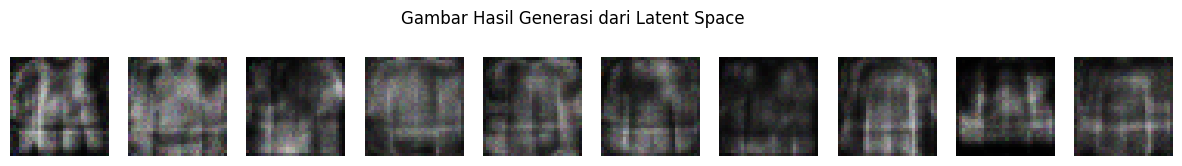

In [13]:
# Tampilkan hasil generasi
generate_images(model)

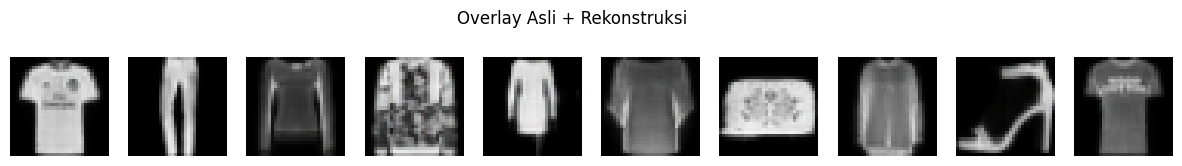

In [14]:
# Tampilkan overlay
show_overlay(model, test_loader, alpha=0.6)